<a href="https://colab.research.google.com/github/Giwa-ibrahim/Giwa_Portfolio/blob/main/LSTM_Wind_Speed_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#Import all necessary files
import numpy as np
import sklearn
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, GRU, SimpleRNN
from tensorflow.keras.layers import Dense, Dropout
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler

In [ ]:
#Read the csv file
df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Datasets/wsp_for_one_feature.csv')
print(df.head()) #7 columns, including the Date.

       date  wsp
0  1/1/2008   10
1  1/2/2008   14
2  1/3/2008   15
3  1/4/2008    7
4  1/5/2008    8


Plot Loading... 


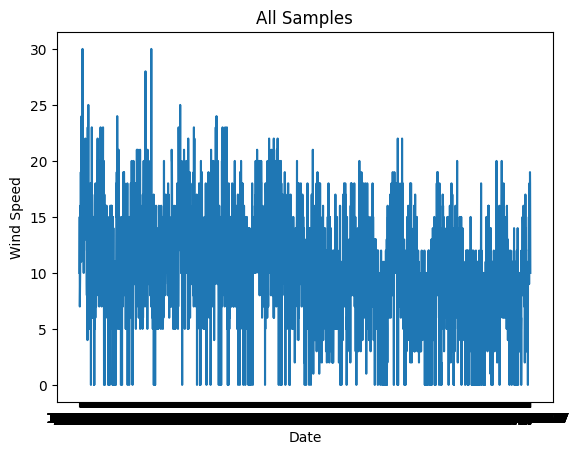

In [ ]:
# Plotting all the Wind speed data
print("Plot Loading... ")
plt.plot(df["date"], df["wsp"])
plt.title("All Samples")
plt.xlabel("Date")
plt.ylabel("Wind Speed")
plt.show()


In [ ]:
#Plot Training Data
train_date= df.loc[0:2556, 'date']
train_wsp= df.loc[0:2556,'wsp']
train_date= pd.DataFrame(train_date)
train_wsp= pd.DataFrame(train_wsp)
train_data  = train_date.join(train_wsp,how='outer')

plt.plot(train_data["date"], train_data["wsp"])
plt.title("Training Data")
plt.xlabel("Date")
plt.ylabel("Wind Speed")
plt.show()


In [ ]:
#Plot Testing Data
test_date= df.loc[2557:3652, 'date']
test_wsp= df.loc[2557:3652,'wsp']
test_date= pd.DataFrame(test_date)
test_wsp= pd.DataFrame(test_wsp)
test_data  = test_date.join(test_wsp,how='outer')

plt.plot(test_data["date"], test_data["wsp"])
plt.title("Testing Data")
plt.xlabel("Date")
plt.ylabel("Wind Speed")
plt.show()

In [ ]:
#Variables for training
cols = list(df)[1:2]
#Date and volume columns are not used in training.
print(cols) #['wsp']

df_for_training = df[cols].astype(float)

raw = df['wsp'].tolist()

['wsp']


In [ ]:
# univariate data preparation
from numpy import array

# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
    X = list()
    for i in range(len(sequence)):
        # find the end of this pattern
        end_ix = i + n_steps
        # check if we are beyond the sequence
        if end_ix > len(sequence)-1:
            break
        # gather input and output parts of the pattern
        seq_x = sequence[i:end_ix]
        X.append(seq_x)

    return array(X)

In [ ]:
# define input sequence
#raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 6
# split into samples
X= split_sequence(raw, n_steps)

In [ ]:
#Pre-processed dataset
df = pd.DataFrame(X)
df_for_training = df.astype(float)
print(df_for_training.head())

      0     1     2     3     4     5
0  10.0  14.0  15.0   7.0   8.0   9.0
1  14.0  15.0   7.0   8.0   9.0  10.0
2  15.0   7.0   8.0   9.0  10.0  13.0
3   7.0   8.0   9.0  10.0  13.0  16.0
4   8.0   9.0  10.0  13.0  16.0  16.0


In [ ]:
#Standardize the datasets
scaler = StandardScaler()
scaler = scaler.fit(df_for_training)
df_for_training_scaled = scaler.transform(df_for_training)

In [ ]:
#Empty lists to be populated using formatted training data
X = []
Y = []

n_future = 1   # Number of days we want to look into the future based on the past days.
n_past = 1  # Number of past days we want to use to predict the future.

#Reformat input data into a shape: (n_samples x timesteps x n_features)
#In this example, df_for_training_scaled has a shape (3653, 1)
#3653 refers to the number of data points and 1 refers to the columns (single-variable).
for i in range(n_past, len(df_for_training_scaled) - n_future +1):
    X.append(df_for_training_scaled[i - n_past:i, 0:df_for_training.shape[1]])
    Y.append(df_for_training_scaled[i + n_future - 1:i + n_future, 0])

X, Y = np.array(X), np.array(Y)
print('X shape == {}.'.format(X.shape))
print('Y shape == {}.'.format(Y.shape))

X shape == (3646, 1, 6).
Y shape == (3646, 1).


In [ ]:
#Splitting data to testing and training sets
from sklearn.model_selection import train_test_split
X_train, X_test,y_train, y_test= train_test_split(X, Y, test_size= 0.3, random_state= 10)


ANN Model

In [ ]:
def plot_loss(history):
    """Plot the learning curve
    """
    plt.plot(range(1, len(history.history['loss']) + 1), history.history['loss'])
    plt.plot(range(1, len(history.history['val_loss']) + 1), history.history['val_loss'])
    plt.title('Model Loss Training')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Training loss', 'Validation loss'], loc = 'best')
    plt.show()

In [ ]:
# Build the model
ann_1 = Sequential()
ann_1.add(Dense(40, activation = 'relu', input_shape=(X_train.shape[1], X_train.shape[2])))
#ann_1.add(Dense(16, activation = 'relu'))
#ann_1.add(Dense(1))
ann_1.add(Dense(y_train.shape[1]))
ann_1.summary()

Model: "sequential_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 1, 40)             280       
                                                                 
 dense_16 (Dense)            (None, 1, 1)              41        
                                                                 
Total params: 321
Trainable params: 321
Non-trainable params: 0
_________________________________________________________________


In [ ]:
ann_1.compile(optimizer = 'adam', loss = 'mean_absolute_error')
history_ann_1 = ann_1.fit(X_train, y_train, epochs = 20, batch_size = 48, verbose = 1, validation_split = 0.1)

Epoch 1/20
48/48 [==============================] - 1s 6ms/step - loss: 0.9668 - val_loss: 0.7916
Epoch 2/20
48/48 [==============================] - 0s 3ms/step - loss: 0.6056 - val_loss: 0.5172
Epoch 3/20
48/48 [==============================] - 0s 3ms/step - loss: 0.3718 - val_loss: 0.2676
Epoch 4/20
48/48 [==============================] - 0s 3ms/step - loss: 0.1530 - val_loss: 0.0942
Epoch 5/20
48/48 [==============================] - 0s 3ms/step - loss: 0.0863 - val_loss: 0.0778
Epoch 6/20
48/48 [==============================] - 0s 3ms/step - loss: 0.0716 - val_loss: 0.0705
Epoch 7/20
48/48 [==============================] - 0s 3ms/step - loss: 0.0633 - val_loss: 0.0648
Epoch 8/20
48/48 [==============================] - 0s 2ms/step - loss: 0.0581 - val_loss: 0.0609
Epoch 9/20
48/48 [==============================] - 0s 3ms/step - loss: 0.0545 - val_loss: 0.0564
Epoch 10/20
48/48 [==============================] - 0s 2ms/step - loss: 0.0511 - val_loss: 0.0535
Epoch 11/20
48/48 [

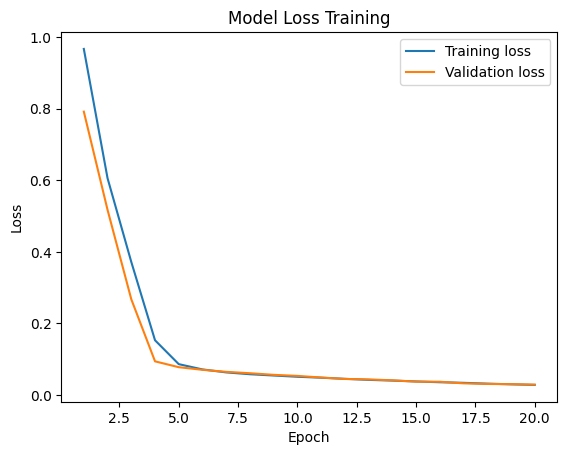

In [ ]:
plot_loss(history_ann_1)

In [ ]:
#Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = ann_1.evaluate(X_test, y_test, batch_size=16)
print("test loss, test acc:", results)

Evaluate on test data
69/69 [==============================] - 0s 2ms/step - loss: 0.0293
test loss, test acc: 0.029286079108715057


In [ ]:
#Make prediction
prediction_ann = ann_1.predict(X_test)

35/35 [==============================] - 0s 2ms/step


In [ ]:
prediction_ann = prediction_ann.reshape(1094, 1)

In [ ]:
#Unstandardize the y_pred and y_test
prediction_copies_ann = np.repeat(prediction_ann, df_for_training.shape[1], axis=-1)
prediction_copies_ann.shape
y_pred_ann = scaler.inverse_transform(prediction_copies_ann)[:,0].astype(float)
y_test_copies_ann = np.repeat(y_test, df_for_training.shape[1], axis=-1)
y_true_ann = scaler.inverse_transform(y_test_copies_ann)[:,0]

In [ ]:
#Performance Metrics for ANN
mse_ann = sklearn.metrics.mean_squared_error(y_pred_ann,y_true_ann)
import math
rmse_ann = math.sqrt(mse_ann)
mae_ann= sklearn.metrics.mean_absolute_error(y_pred_ann,y_true_ann)
r2_ann= sklearn.metrics.r2_score(y_pred_ann,y_true_ann)#Coefficient of Determination (R2)
me_ann= sklearn.metrics.max_error(y_true_ann, y_pred_ann)
from sklearn.metrics import mean_absolute_percentage_error
mape_ann= mean_absolute_percentage_error(y_pred_ann, y_true_ann)
r_ann = np.corrcoef(y_pred_ann, y_true_ann)

In [ ]:
#Print all Performance metrics
print(f'me= {me_ann}')
print(f'mse= {mse_ann}')
print(f'mae= {mae_ann}')
print(f'rmse= {rmse_ann}')
print(f'r2= {r2_ann}')
print(f'mape= {mape_ann}')

me= 0.7541494369506836
mse= 0.03029684375396499
mae= 0.13499691821928467
rmse= 0.17405988553933094
r2= 0.9986349952513681
mape= 0.0516611908645283


LSTM, GRU and SimpleRNN Model

In [ ]:
#Stacked LSTM Architecture
model = Sequential()
model.add(LSTM(40, activation='relu', input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=False))
#model.add(LSTM(100, activation='tanh', return_sequences=False))
# model.add(LSTM(50, activation='relu', return_sequences=False))
model.add(Dropout(0.1))
model.add(Dense(y_train.shape[1]))

# model.compile(optimizer='adam', loss='mse')
model.compile(
    optimizer="adam",
    loss="mse",
)
model.summary()


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 40)                7520      
                                                                 
 dropout_1 (Dropout)         (None, 40)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 41        
                                                                 
Total params: 7,561
Trainable params: 7,561
Non-trainable params: 0
_________________________________________________________________


Epoch 1/20
48/48 [==============================] - 2s 13ms/step - loss: 0.8630 - val_loss: 0.7722
Epoch 2/20
48/48 [==============================] - 0s 5ms/step - loss: 0.5609 - val_loss: 0.4562
Epoch 3/20
48/48 [==============================] - 0s 5ms/step - loss: 0.3458 - val_loss: 0.2632
Epoch 4/20
48/48 [==============================] - 0s 5ms/step - loss: 0.1924 - val_loss: 0.1165
Epoch 5/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0803 - val_loss: 0.0344
Epoch 6/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0308 - val_loss: 0.0098
Epoch 7/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0196 - val_loss: 0.0045
Epoch 8/20
48/48 [==============================] - 0s 6ms/step - loss: 0.0172 - val_loss: 0.0027
Epoch 9/20
48/48 [==============================] - 0s 6ms/step - loss: 0.0147 - val_loss: 0.0022
Epoch 10/20
48/48 [==============================] - 0s 5ms/step - loss: 0.0143 - val_loss: 0.0018
Epoch 11/20
48/48 

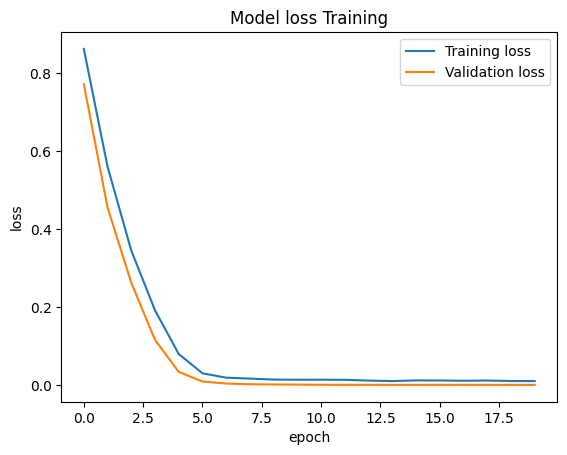

In [ ]:
# fit the model
history = model.fit(X_train, y_train, epochs=20, batch_size=48, validation_split=0.1, verbose=1)

plt.plot(history.history['loss'], label='Training loss')
plt.plot(history.history['val_loss'], label='Validation loss')
plt.title("Model loss Training")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [ ]:
#Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(X_test, y_test, batch_size=16)
print("test loss, test acc:", results)


Evaluate on test data
69/69 [==============================] - 0s 1ms/step - loss: 0.0012
test loss, test acc: 0.0011530977208167315


In [ ]:
#Make prediction
prediction = model.predict(X_test)


35/35 [==============================] - 0s 2ms/step


In [ ]:
#Unstandardize the y_pred and y_test
prediction_copies = np.repeat(prediction, df_for_training.shape[1], axis=-1)
y_pred = scaler.inverse_transform(prediction_copies)[:,0].astype(float)
y_test_copies = np.repeat(y_test, df_for_training.shape[1], axis=-1)
y_true = scaler.inverse_transform(y_test_copies)[:,0]

In [ ]:
#Performance Metrics
mse = sklearn.metrics.mean_squared_error(y_pred,y_true)
import math
rmse = math.sqrt(mse)
mae= sklearn.metrics.mean_absolute_error(y_pred,y_true)
r2= sklearn.metrics.r2_score(y_pred,y_true)#Coefficient of Determination (R2)
me= sklearn.metrics.max_error(y_true, y_pred)
from sklearn.metrics import mean_absolute_percentage_error
mape= mean_absolute_percentage_error(y_pred, y_true)
r = np.corrcoef(y_pred, y_true)


In [ ]:
#Print all Performance metrics
print(f'me= {me}')
print(f'mse= {mse}')
print(f'mae= {mae}')
print(f'rmse= {rmse}')
print(f'r2= {r2}')
print(f'mape= {mape}')


me= 1.890054702758789
mse= 0.024501416437675474
mae= 0.1114744259199039
rmse= 0.1565292830037737
r2= 0.9988741248265628
mape= 0.047711585269957356


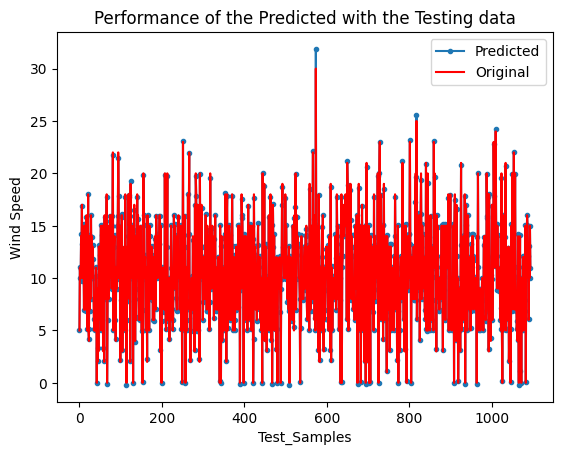

In [ ]:
#Plotting the Predicted and Testing data
plt.title('Performance of the Predicted with the Testing data')
plt.plot(y_pred.flatten(),marker= '.', label='Predicted')
plt.plot(y_true.flatten(),'r', label='Original')
plt.xlabel("Test_Samples")
plt.ylabel("Wind Speed")
plt.legend()

Comparison of Performance Metrics for Different Models

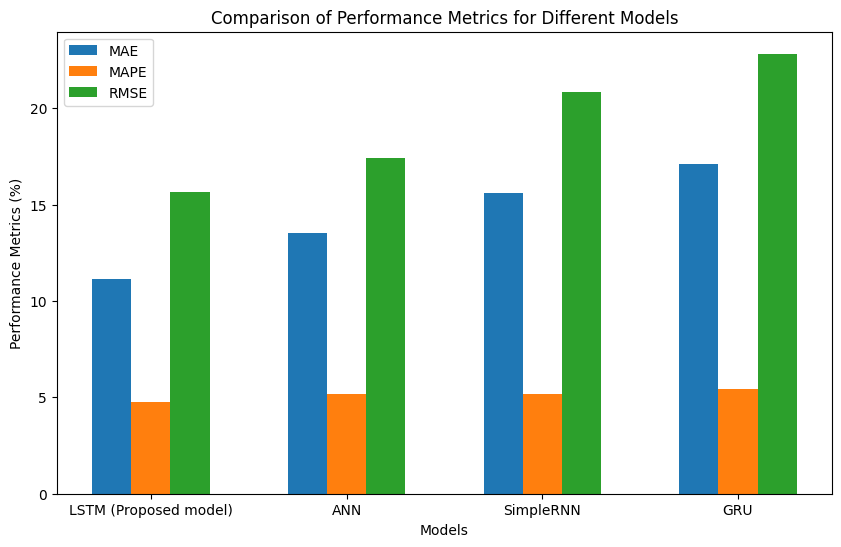

In [ ]:
import matplotlib.pyplot as plt

# Data for the table
models = ['LSTM (Proposed model)', 'ANN', 'SimpleRNN', 'GRU']
mae = [11.14, 13.50, 15.62, 17.11]
mape = [4.78, 5.17, 5.18, 5.42]
rmse = [15.65, 17.41, 20.82, 22.82]

# Create a bar plot
x = range(len(models))
width = 0.2

plt.figure(figsize=(10, 6))
plt.bar(x, mae, width=width, label='MAE')
plt.bar([i + width for i in x], mape, width=width, label='MAPE')
plt.bar([i + width * 2 for i in x], rmse, width=width, label='RMSE')

# Add labels and title
plt.xlabel('Models')
plt.ylabel('Performance Metrics (%)')
plt.title('Comparison of Performance Metrics for Different Models')

# Customize x-axis labels
plt.xticks([i + width for i in x], models)

# Add legend
plt.legend()

# Display the plot
plt.show()
